# Market Neutral portfolio using cvxpy optimizer and Pairs Trading

## 1. Load Data

In [43]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as plt
from collections import defaultdict
import math
import matplotlib.pyplot as plt

import seaborn as sns
import datetime as dt
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [28]:
import yfinance as yf
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

# Define the list of tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Specify the date range
start_date = '2020-01-01'
end_date = '2021-12-31'

# Download historical data
data = yf.download(tickers + ['^GSPC'], start=start_date, end=end_date)

# Calculate daily returns
daily_returns = data['Adj Close'].pct_change()

# Print the first few rows of daily returns
print(daily_returns.head())


[*********************100%%**********************]  6 of 6 completed
                AAPL      AMZN     GOOGL      MSFT      TSLA     ^GSPC
Date                                                                  
2020-01-02       NaN       NaN       NaN       NaN       NaN       NaN
2020-01-03 -0.009722 -0.012139 -0.005231 -0.012452  0.029633 -0.007060
2020-01-06  0.007968  0.014886  0.026654  0.002585  0.019255  0.003533
2020-01-07 -0.004703  0.002092 -0.001932 -0.009118  0.038801 -0.002803
2020-01-08  0.016086 -0.007809  0.007118  0.015928  0.049205  0.004902


In [29]:
daily_returns

,AAPL,AMZN,GOOGL,MSFT,TSLA,^GSPC
Date,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.009722,-0.012139,-0.005231,-0.012452,0.029633,-0.007060
2020-01-06,0.007968,0.014886,0.026654,0.002585,0.019255,0.003533
2020-01-07,-0.004703,0.002092,-0.001932,-0.009118,0.038801,-0.002803
2020-01-08,0.016086,-0.007809,0.007118,0.015928,0.049205,0.004902
...,...,...,...,...,...,...
2021-12-23,0.003644,0.000184,0.003425,0.004472,0.057619,0.006224
2021-12-27,0.022975,-0.008178,0.006738,0.023186,0.025248,0.013839
2021-12-28,-0.005767,0.005844,-0.008245,-0.003504,-0.005000,-0.001010


In [30]:
full_covmat = daily_returns.cov()
full_covmat.head()

,AAPL,AMZN,GOOGL,MSFT,TSLA,^GSPC
AAPL,0.000558,0.000321,0.000334,0.000413,0.000516,0.000310
AMZN,0.000321,0.000410,0.000266,0.000306,0.000403,0.000196
GOOGL,0.000334,0.000266,0.000411,0.000361,0.000381,0.000269
MSFT,0.000413,0.000306,0.000361,0.000471,0.000484,0.000303
TSLA,0.000516,0.000403,0.000381,0.000484,0.002197,0.000354


In [31]:
betas = full_covmat["^GSPC"].drop("^GSPC") / full_covmat.loc["^GSPC", "^GSPC"]  # extract cov and mkt var
betas.head()

AAPL     1.146430
AMZN     0.726241
GOOGL    0.995751
MSFT     1.123763
TSLA     1.311414
Name: ^GSPC, dtype: float64

In [32]:
daily_returns

,AAPL,AMZN,GOOGL,MSFT,TSLA,^GSPC
Date,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.009722,-0.012139,-0.005231,-0.012452,0.029633,-0.007060
2020-01-06,0.007968,0.014886,0.026654,0.002585,0.019255,0.003533
2020-01-07,-0.004703,0.002092,-0.001932,-0.009118,0.038801,-0.002803
2020-01-08,0.016086,-0.007809,0.007118,0.015928,0.049205,0.004902
...,...,...,...,...,...,...
2021-12-23,0.003644,0.000184,0.003425,0.004472,0.057619,0.006224
2021-12-27,0.022975,-0.008178,0.006738,0.023186,0.025248,0.013839
2021-12-28,-0.005767,0.005844,-0.008245,-0.003504,-0.005000,-0.001010


In [33]:
def get_mkt_neutral_weights():

    weights = cp.Variable(len(daily_returns.columns)-1)

    # Create objective "risk" function to be minimized:
    # See here: https://www.cvxpy.org/examples/basic/quadratic_program.html
    # that (1/2)*x.transposed*P*x+q.transposed*x is equal to (1/2)*cp.quad_form(x, P) + q.T @ x
    # This means that w.transposed() * covar-matrix * w (our risk measure "variance")
    #   is equal to cp.quad_form(weights, covariance_matrix)
    objective = cp.quad_form(weights, daily_returns[tickers].cov())

    # Create constraints list: sum of weights should be 1 and only long assets (every weight > 0)
    constraint = [sum(weights) == 1]
    for i in range(5):
        constraint.append(weights[i] >= 0)

    # Solve formulated problem with cvxpy library
    problem = cp.Problem(cp.Minimize(objective), constraint)
    problem.solve()
    # Save optimized weight-values in "optimized_weights"
    optimized_weights = []
    for i in range(len(weights.value)):
        optimized_weights.append(weights.value[i])
    # Return solution
    return optimized_weights

In [34]:
w = pd.Series(get_mkt_neutral_weights(), index= daily_returns[tickers].cov().columns)
w.round(4).head()

AAPL     0.0409
MSFT     0.0114
GOOGL    0.4685
AMZN     0.4792
TSLA     0.0000
dtype: float64

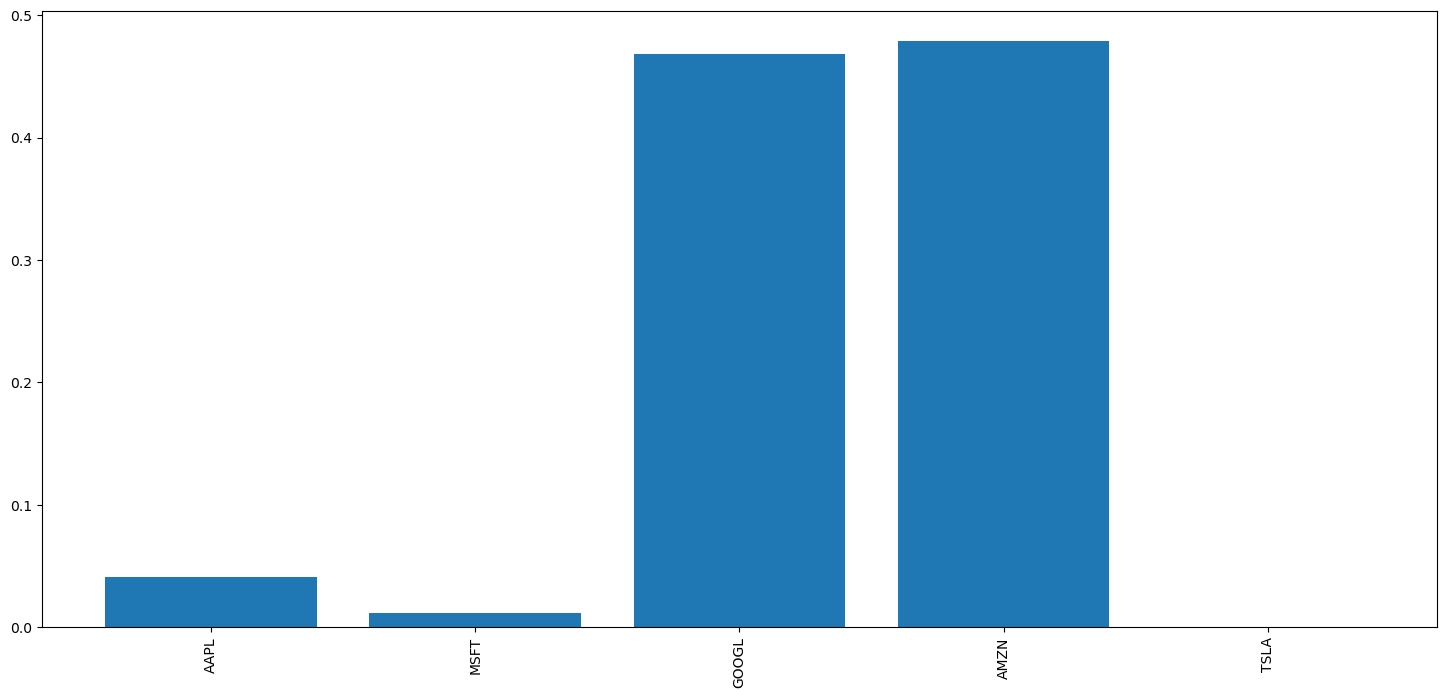

In [35]:
plt.figure(figsize=(18, 8))
plt.bar(w.index, w.values)
plt.xticks(rotation = 90);

In [36]:
roll_covmat = daily_returns.rolling(window=12).cov().dropna()
roll_covmat.head()

AAPL      AMZN     GOOGL      MSFT      TSLA     ^GSPC
Date                                                                        
2020-01-21 AAPL   0.000149  0.000035  0.000073  0.000107  0.000010  0.000051
           AMZN   0.000035  0.000095  0.000040  0.000030  0.000084  0.000018
           GOOGL  0.000073  0.000040  0.000092  0.000050 -0.000092  0.000028
           MSFT   0.000107  0.000030  0.000050  0.000107 -0.000055  0.000048
           TSLA   0.000010  0.000084 -0.000092 -0.000055  0.001564 -0.000023

In [37]:

for date in daily_returns.index:
    # Filter data for the current date
    returns_on_date = daily_returns.loc[date]
    selected_returns = returns_on_date[tickers]

In [38]:
returns_on_date

AAPL    -0.006578
AMZN    -0.003289
GOOGL   -0.003099
MSFT    -0.007691
TSLA    -0.014592
^GSPC   -0.002990
Name: 2021-12-30 00:00:00, dtype: float64

In [39]:
import yfinance as yf
import pandas as pd
import cvxpy as cp

# Define the list of tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Specify the date range
start_date = '2020-01-01'
end_date = '2021-12-31'

# Download historical data
data = yf.download(tickers + ['^GSPC'], start=start_date, end=end_date)

# Calculate daily returns
daily_returns = data['Adj Close'].pct_change()
# Initialize a DataFrame to store daily portfolio weights
# Initialize a DataFrame to store daily portfolio weights
portfolio_weights = pd.DataFrame(index=daily_returns.index, columns=tickers)

for date in daily_returns.index:
    # Filter data for the current date
    returns_on_date = daily_returns[tickers].shift(-1)
    '''
        # Select the returns for the specified tickers
        selected_returns = returns_on_date[tickers]
        returns_today = daily_returns.shift(-1)
    '''
    # Calculate the covariance matrix between today's and tomorrow's returns
    covariance_matrix = returns_on_date.cov()
    # Calculate the covariance matrix for the selected tickers
    #covariance_matrix = selected_returns.cov()

    # Create optimization variables for the current date
    weights = cp.Variable(len(tickers))

    # Create objective "risk" function to be minimized
    objective = cp.quad_form(weights, covariance_matrix)
    constraint = [sum(weights) == 1]
    for i in range(5):
        constraint.append(weights[i] >= 0)

    # Solve formulated problem with cvxpy library
    problem = cp.Problem(cp.Minimize(objective), constraint)
    problem.solve()

    # Save optimized weight-values in the portfolio_weights DataFrame
    portfolio_weights.loc[date] = weights.value


[*********************100%%**********************]  6 of 6 completed


In [40]:
portfolio_weights

,AAPL,MSFT,GOOGL,AMZN,TSLA
Date,,,,,
2020-01-02,0.040946,0.01135,0.468484,0.479219,0.0
2020-01-03,0.040946,0.01135,0.468484,0.479219,0.0
2020-01-06,0.040946,0.01135,0.468484,0.479219,0.0
2020-01-07,0.040946,0.01135,0.468484,0.479219,0.0
2020-01-08,0.040946,0.01135,0.468484,0.479219,0.0
...,...,...,...,...,...
2021-12-23,0.040946,0.01135,0.468484,0.479219,0.0
2021-12-27,0.040946,0.01135,0.468484,0.479219,0.0
2021-12-28,0.040946,0.01135,0.468484,0.479219,0.0


In [41]:
roll_covmat = daily_returns[tickers].rolling(2, min_periods=1).cov().dropna()
roll_covmat

AAPL      MSFT     GOOGL      AMZN      TSLA
Date                                                              
2020-01-06 AAPL   0.000156  0.000133  0.000282  0.000239 -0.000092
           MSFT   0.000133  0.000113  0.000240  0.000203 -0.000078
           GOOGL  0.000282  0.000240  0.000508  0.000431 -0.000165
           AMZN   0.000239  0.000203  0.000431  0.000365 -0.000140
           TSLA  -0.000092 -0.000078 -0.000165 -0.000140  0.000054
...                    ...       ...       ...       ...       ...
2021-12-30 AAPL   0.000025  0.000034  0.000010 -0.000019  0.000044
           MSFT   0.000034  0.000047  0.000014 -0.000026  0.000061
           GOOGL  0.000010  0.000014  0.000004 -0.000008  0.000018
           AMZN  -0.000019 -0.000026 -0.000008  0.000014 -0.000033
           TSLA   0.000044  0.000061  0.000018 -0.000033  0.000078

[2510 rows x 5 columns]

In [44]:
emerging_market_countries = ['BRA','MEX','IND','CHN','ZAF']
developed_market_countries = ['USA','JPN','DEU','GBR','FRA']

In [45]:
portfolio = {   'BRA': ['PBR','VALE','ITUB','NU','BSBR'],
                'MEX': ['AMX','KCDMY','VLRS','ALFAA.MX','BBAJIOO.MX'],
                'IND': ['RELIANCE.NS','TCS', 'HDB', 'INFY', 'ADANIENT.NS'],
                'USA': ['AAPL', 'MSFT','GOOG','AMZN','NVDA']
                }

stock_mapping = {}
for country in portfolio:
    for stock in portfolio[country]:
        stock_mapping[stock] = country

In [46]:
def get_data(portfolio, start_date, end_date):
    # Initialize an empty DataFrame
    data = pd.DataFrame()

    # Create an empty list for columns
    columns = []

    # Loop through each country in the portfolio
    for country, tickers in portfolio.items():
        # Download data for each ticker
        df = yf.download(tickers, start=start_date, end=end_date)

        # Extract the columns representing stock attributes (e.g., 'Adj Close', 'Volume', etc.)
        stock_attributes = df.columns.levels[0]

        # Extend the list of columns with country and attribute prefix
        country_columns = [(country, attr, ticker) for ticker in tickers for attr in stock_attributes]
        columns.extend(country_columns)

        # Concatenate the data to the main DataFrame
        data = pd.concat([data, df], axis=1)

    # Create a multi-index header
    data.columns = pd.MultiIndex.from_tuples(columns)
    return data

In [47]:
# sample output from get_data function
data = get_data(portfolio, start_date='2015-01-01', end_date='2023-01-01')
data.interpolate(method = 'linear', inplace = True, limit_direction = 'both')
# print all the adjusted closing prices of the stocks in BRA
data["BRA"]["Adj Close"]

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed


,PBR,VALE,ITUB,NU,BSBR
Date,,,,,
2015-01-01,2.880133,6.280447,12.240,6.710,8.020000
2015-01-02,2.880133,6.280447,12.240,6.710,8.020000
2015-01-05,2.820749,6.205501,12.240,6.050,7.630000
2015-01-06,2.838564,6.405356,12.240,5.790,7.980000
2015-01-07,2.987025,6.585226,12.240,6.110,8.390000
...,...,...,...,...,...
2022-12-26,4.997086,4.730000,3.885,10.635,16.575000
2022-12-27,4.913492,4.590000,3.860,10.620,16.639999
2022-12-28,5.034239,4.750000,3.930,10.760,17.080000


/Users/shyryn/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/shyryn/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


[('NU', 'BSBR')]
                            OLS Regression Results                            
Dep. Variable:                   BSBR   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     3318.
Date:                Mon, 26 Feb 2024   Prob (F-statistic):               0.00
Time:                        13:32:15   Log-Likelihood:                -2077.6
No. Observations:                1038   AIC:                             4159.
Df Residuals:                    1036   BIC:                             4169.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8948      0.174   

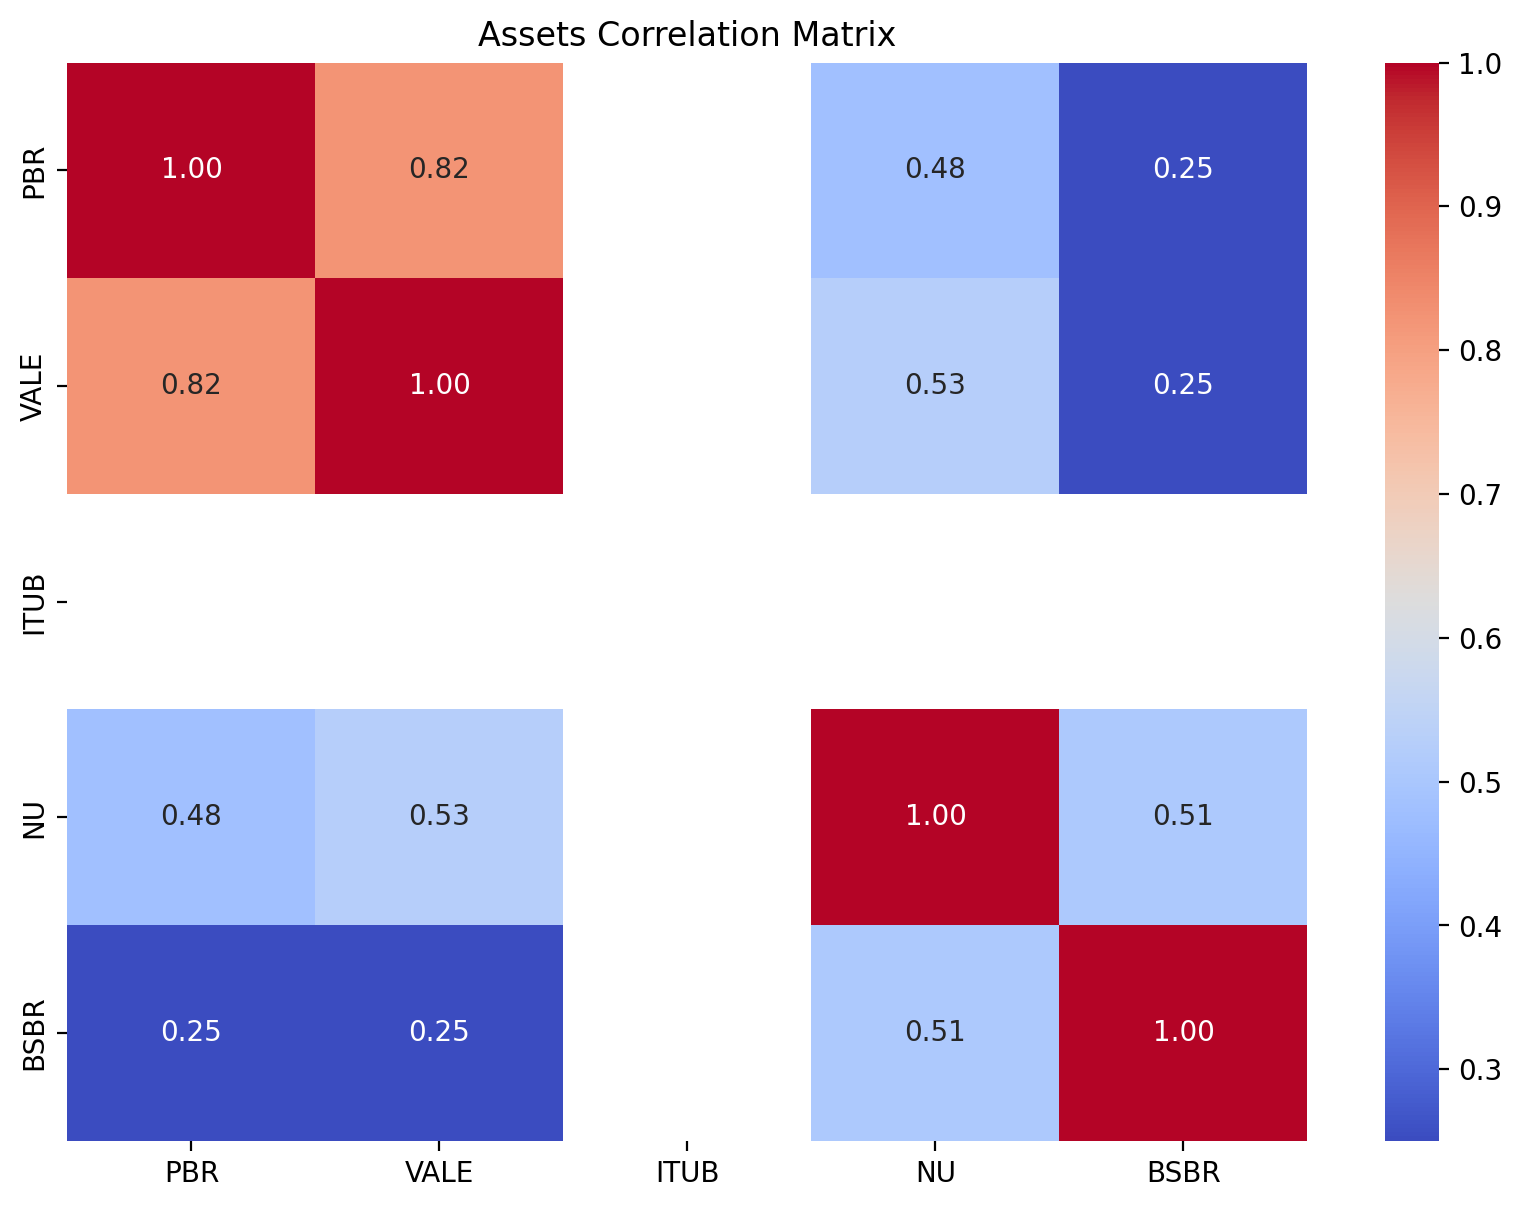

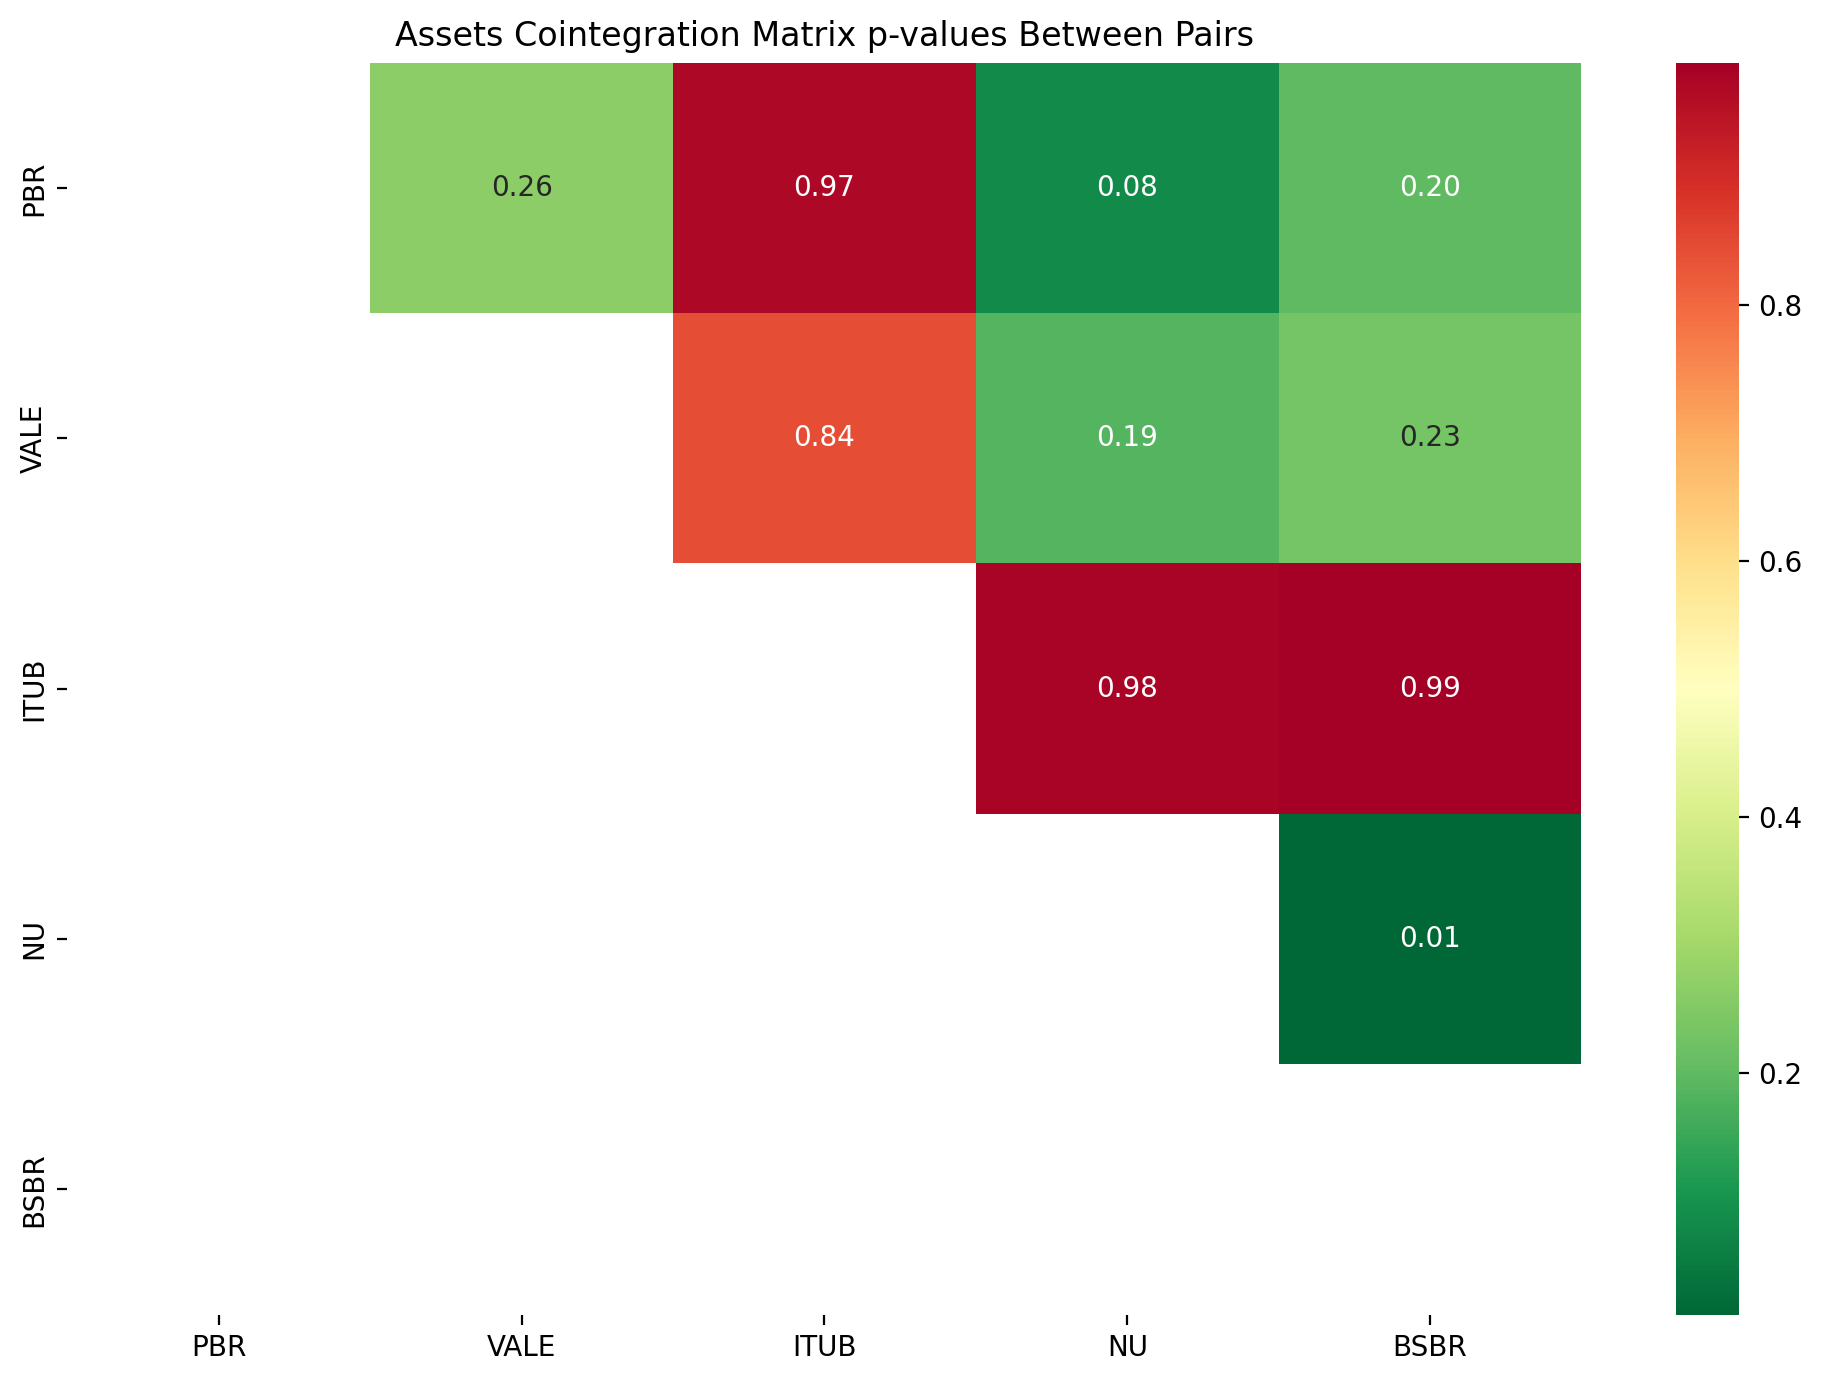

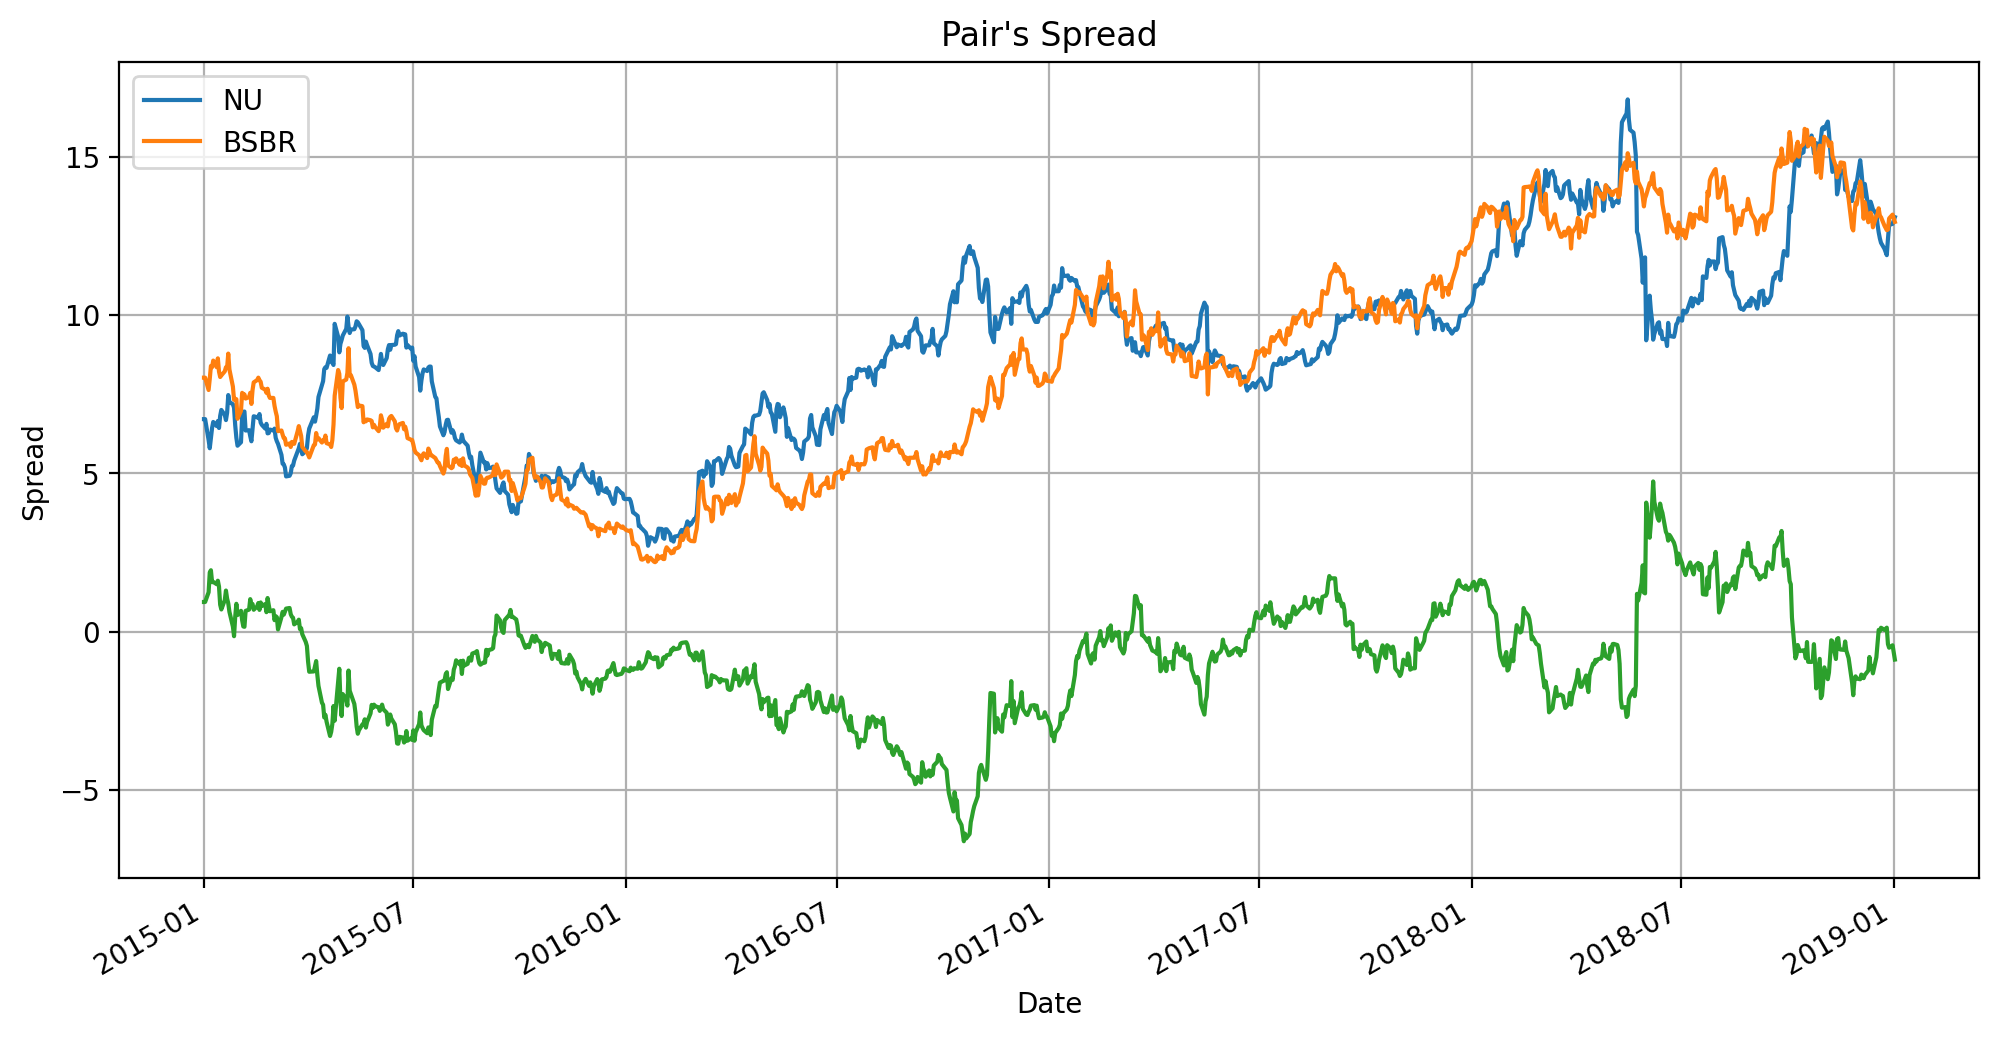

In [49]:
# MY STRATEGY:

train_close, test_close = train_test_split(data["BRA"]["Adj Close"], test_size=0.5, shuffle=False)

# Calculate the Pearson correlation coefficient
correlation_matrix = train_close.pct_change().corr(method='pearson')

# Visualize the correlation matrix
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(correlation_matrix, ax=ax, cmap='coolwarm', annot=True, fmt=".2f")
ax.set_title('Assets Correlation Matrix')

# Define the function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

# Calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(pvalues, xticklabels=train_close.columns,
                yticklabels=train_close.columns, cmap='RdYlGn_r', annot=True, fmt=".2f",
                mask=(pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()

# Select the two assets, 'NU' and 'BSBR', and create a DataFrame
train = pd.DataFrame()
train['NU'] = train_close['NU']
train['BSBR'] = train_close['BSBR']

# Visualize closing prices
ax = train[['NU', 'BSBR']].plot(figsize=(12, 6), title='Daily Closing Prices for NU and BSBR')
ax.set_ylabel("Closing Price")
ax.grid(True)

# Run OLS regression to calculate the hedge ratio
model = sm.OLS(train['BSBR'], sm.add_constant(train['NU'])).fit()
print(model.summary())

# Calculate the spread using the hedge ratio
spread = train['BSBR'] - model.params['NU'] * train['NU']

# Plot the spread
ax = spread.plot(figsize=(12, 6), title="Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True)

# Conduct the Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag=1)
print('Critical Value =', adf[0])
print('Probablity Critical Values:', adf[4])

# Define a function to calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

signals = pd.DataFrame()
signals['NU'] = test_close['NU']
signals['BSBR'] = test_close['BSBR']
ratios = signals.NU / signals.BSBR

# Calculate the z-score for the spread between 'NU' and 'BSBR'
signals['z'] = zscore(spread).values


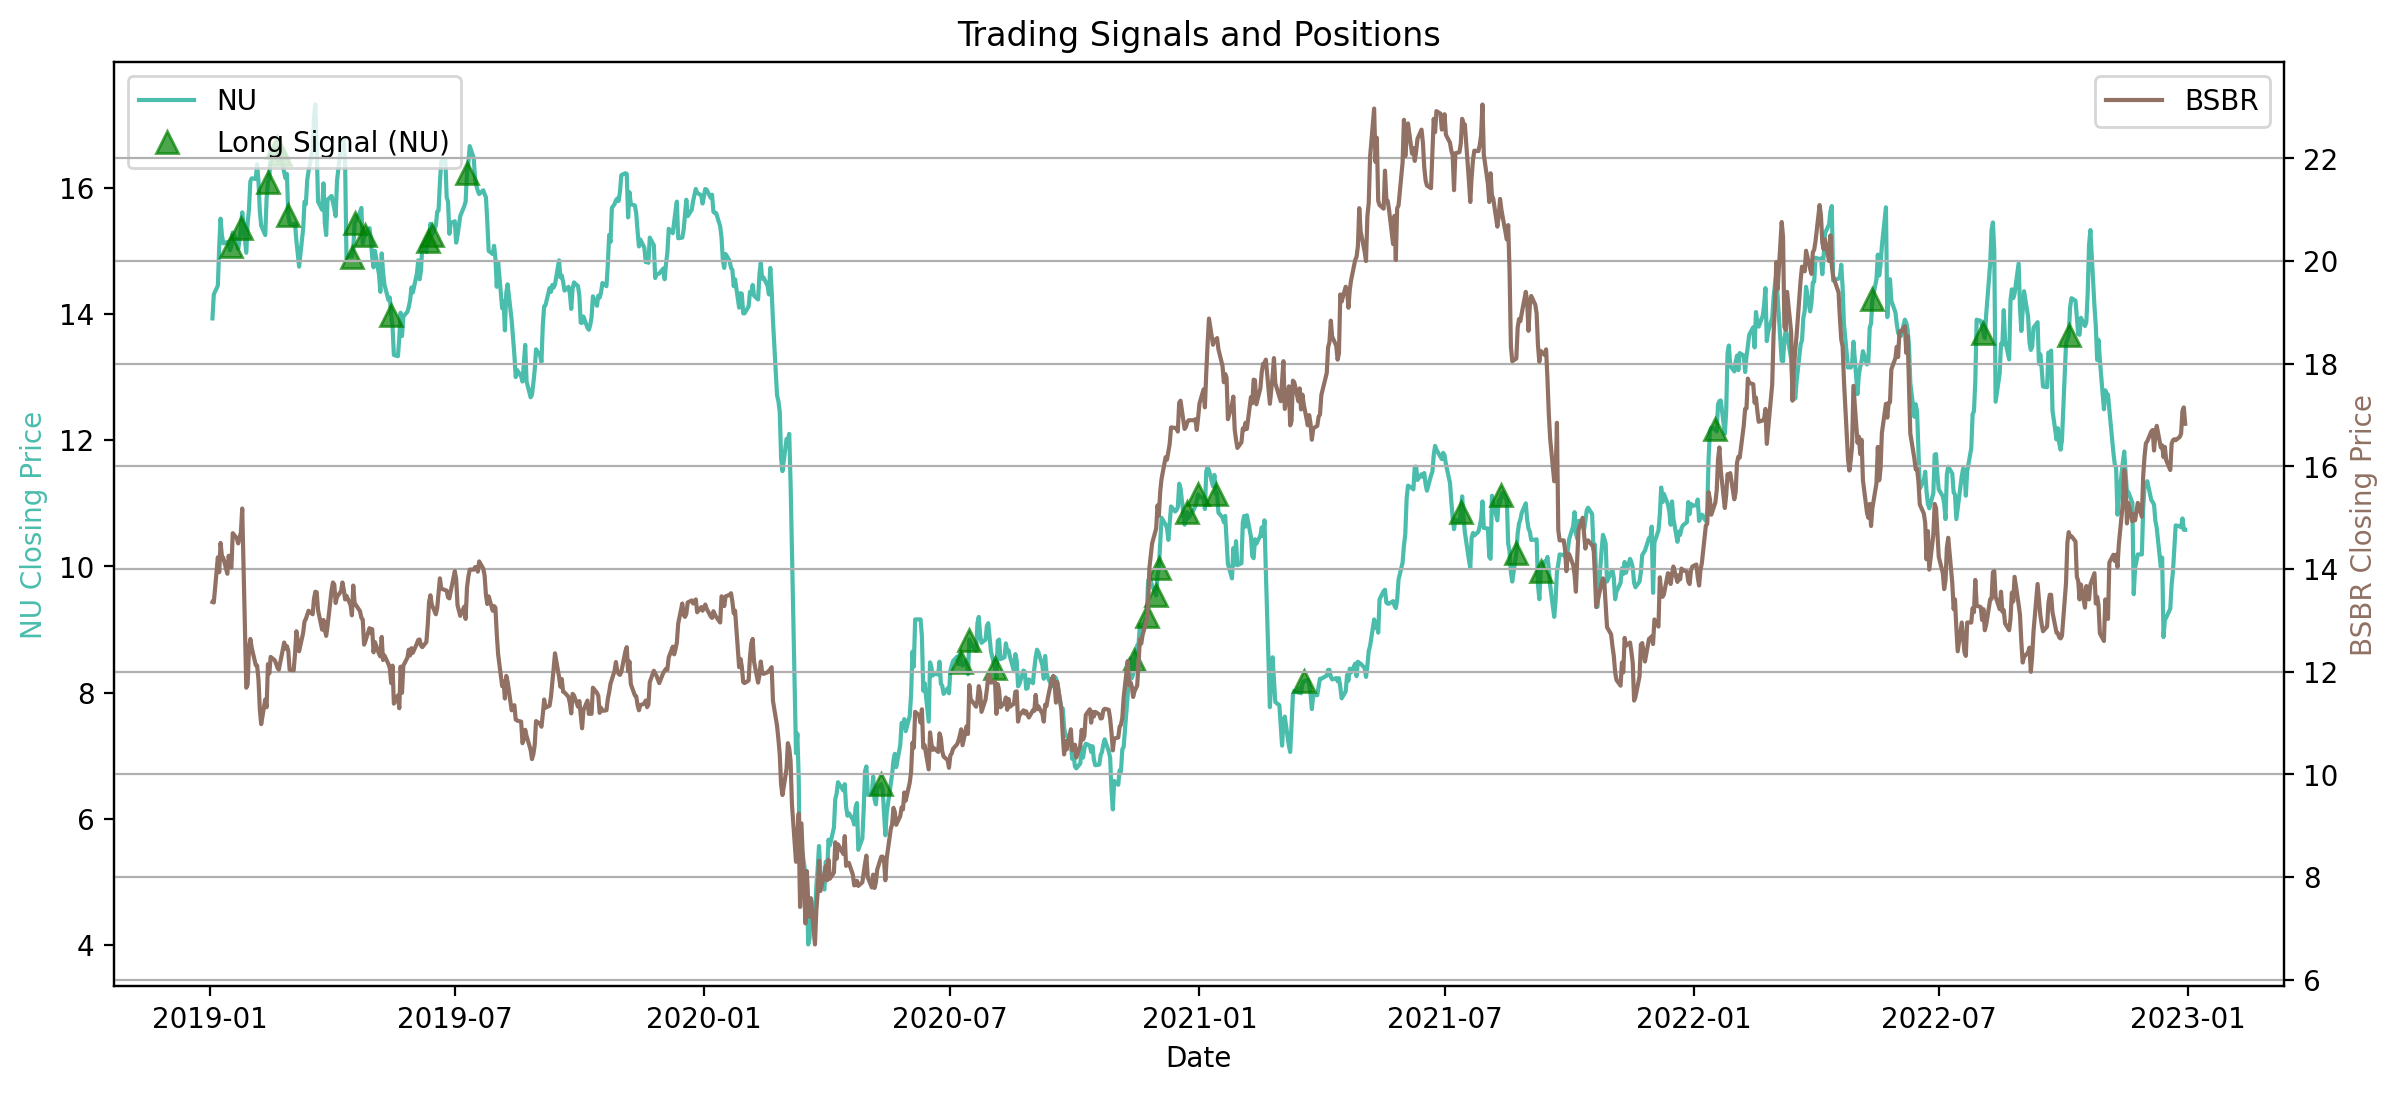

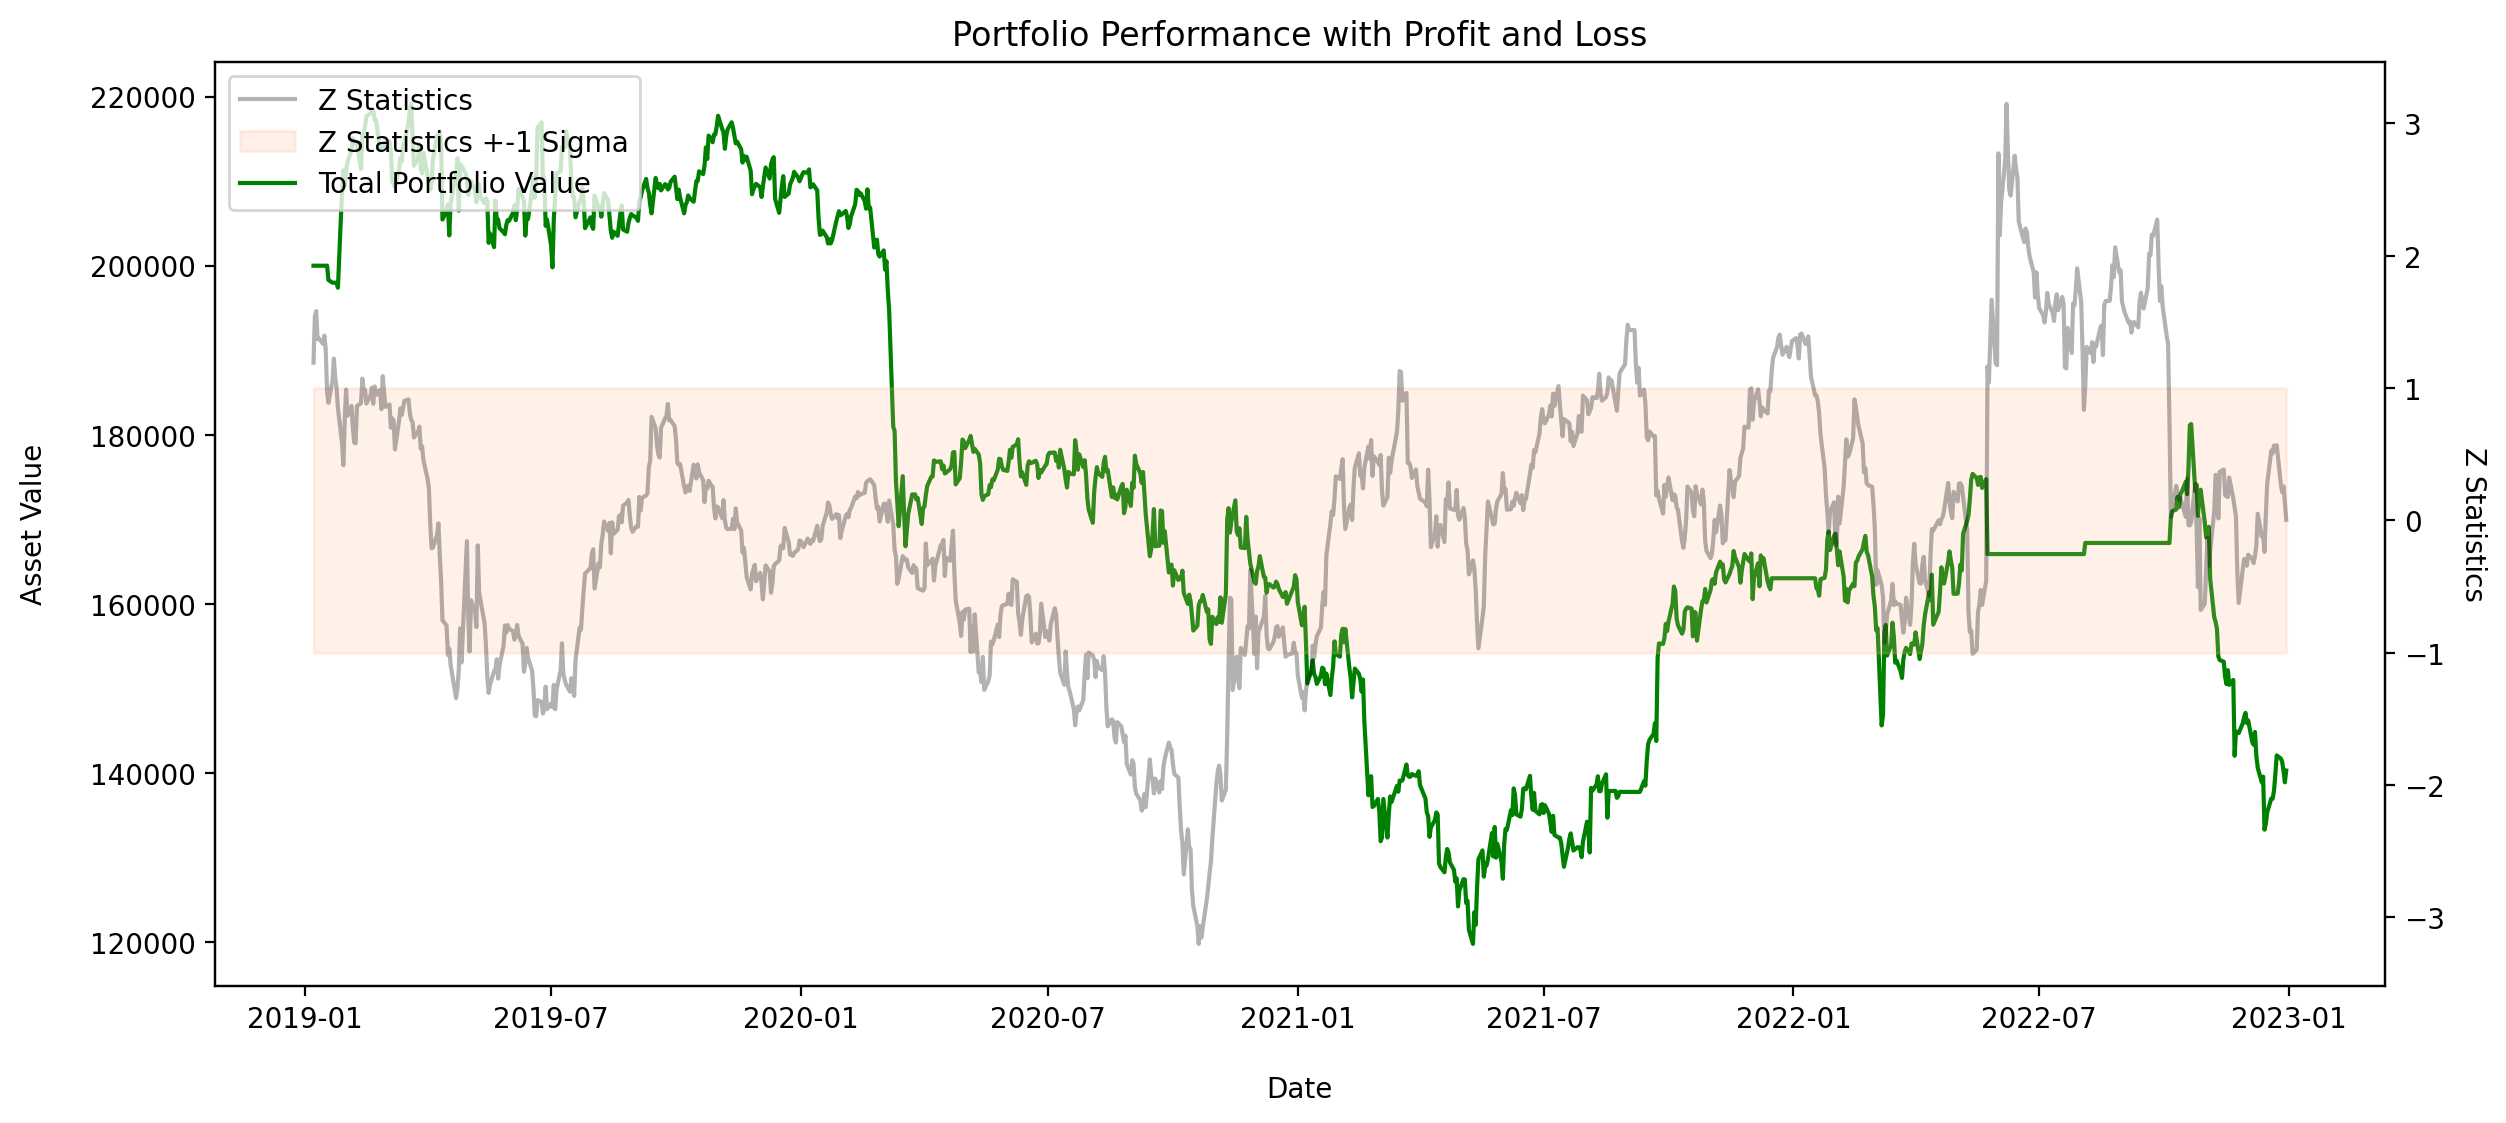

In [50]:

# Define upper and lower thresholds for z-scores
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

# Create trading signals - short if z-score is greater than upper limit, else long
signals['signals1'] = np.select([signals['z'] > signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

# Calculate the first order difference to obtain portfolio position in 'NU' stock
signals['positions1'] = signals['signals1'].diff()

# Create trading signals for 'SBIN'
signals['signals2'] = -signals['signals1']

# Calculate the first order difference to obtain portfolio position in 'BSBR' stock
signals['positions2'] = signals['signals2'].diff()

# Visualize trading signals and positions
fig = plt.figure(figsize=(14, 6))
bx = fig.add_subplot(111)
bx2 = bx.twinx()

# Plot 'NU' and 'SBIN' closing prices
l1, = bx.plot(signals['NU'], c='#4abdac')
l2, = bx2.plot(signals['BSBR'], c='#907163')

# Plot buy (long) signals for 'BANKBARODA'
u1, = bx.plot(signals['NU'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g', alpha=0.7)

# Add legends and labels as needed
bx.set_xlabel('Date')
bx.set_ylabel('NU Closing Price', color='#4abdac')
bx2.set_ylabel('BSBR Closing Price', color='#907163')
bx.legend([l1, u1], ['NU', 'Long Signal (NU)'], loc='upper left')
bx2.legend([l2], ['BSBR'], loc='upper right')
plt.title('Trading Signals and Positions')
plt.grid(True)
plt.show()

# ********************* CHECKING PNL **********************
# Define initial capital
initial_capital = 100000

# Calculate the number of shares to buy for each position
positions1 = initial_capital // max(signals['NU'])
positions2 = initial_capital // max(signals['BSBR'])

portfolio = pd.DataFrame()
portfolio['NU'] = signals['NU']

# Calculate and track holdings, cash, total asset, and returns for asset1
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['NU'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['NU'] * positions1).cumsum()
portfolio['total NU'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total NU'].pct_change()
portfolio['positions1'] = signals['positions1']

# Calculate and track holdings, cash, total asset, and returns for asset2
portfolio['BSBR'] = signals['BSBR']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['BSBR'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['BSBR'] * positions2).cumsum()
portfolio['total BSBR'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total BSBR'].pct_change()
portfolio['positions2'] = signals['positions2']

# Track z-scores, total assets, and upper/lower limits
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total NU'] + portfolio['total BSBR']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

# Plot the asset value change of the portfolio and P&L along with z-scores
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
b = ax2.fill_between(portfolio.index, portfolio['z upper limit'], portfolio['z lower limit'], alpha=0.2, color='#ffb48f')
ax.set_ylabel('Asset Value')
ax2.set_ylabel('Z Statistics', rotation=270)
ax.yaxis.labelpad = 15
ax2.yaxis.labelpad = 15
ax.set_xlabel('Date')
ax.xaxis.labelpad = 15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2, b, l1], ['Z Statistics', 'Z Statistics +-1 Sigma', 'Total Portfolio Value'], loc='upper left')


In [51]:

# Calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
delta = (portfolio.index[-1] - portfolio.index[0]).days
print('Number of days =', delta)
YEAR_DAYS = 365
returns = (final_portfolio / initial_capital) ** (YEAR_DAYS / delta) - 1
print('CAGR = {:.3f}%'.format(returns * 100))


Number of days = 1453
CAGR = 8.871%
